### Importing the important libraries and dataset

To begin, import libraries like pandas and matplotlib/seaborn for data handling and visualization. Perform data preprocessing using NLTK, import email data from CSV file, and import machine learning algorithms like SVC, Random Forest, and Naive Bayes Classifier for model building.

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
import PIL

# Model Building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mulombi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/mulombi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/mulombi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [55]:
#importing the Dataset
data = pd.read_csv("emails_sample.csv",encoding='latin1')

In [56]:
data.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4471,spam,3. You have received your mobile content. Enjoy,NaN,NaN,NaN
498,ham,"Kate jackson rec center before 7ish, right?",NaN,NaN,NaN
4764,ham,if you text on your way to cup stop that shoul...,NaN,NaN,NaN
924,ham,Actually i deleted my old website..now i m blo...,NaN,NaN,NaN
110,ham,What is the plural of the noun research?,NaN,NaN,NaN


### Initial Exploration And Data Cleaning

We will begin by performing an initial exploration and cleaning of the data to ensure we have a high-quality dataset for analysis.

In [57]:
data.shape

(5572, 5)

In [58]:
#remove unwanted columns
data.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], inplace=True)

In [59]:
#rename columns to more intuitive names
data.rename(columns={'v1': 'result', 'v2': 'emails'}, inplace=True)

In [60]:
data.head(5)

,result,emails
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [61]:
#get unique values for results columns
data['result'].value_counts()

result
ham     4825
spam     747
Name: count, dtype: int64

In [62]:
#check for missing values
data.isnull().sum()

result    0
emails    0
dtype: int64

In [63]:
#check for duplicates
data.duplicated().sum()

403

In [64]:
#remove duplicates
data = data.drop_duplicates(keep='first')

In [65]:
data.shape

(5169, 2)

### Exploratory Data Analysis (EDA)

Exploratory Data Analysis (EDA) is a method used to analyze data on spam and regular emails. It involves comparing spam and ham emails, using pie charts, average length, word count, and sentence count, and using heatmaps for correlation.

 **1) Distribution of Labels**

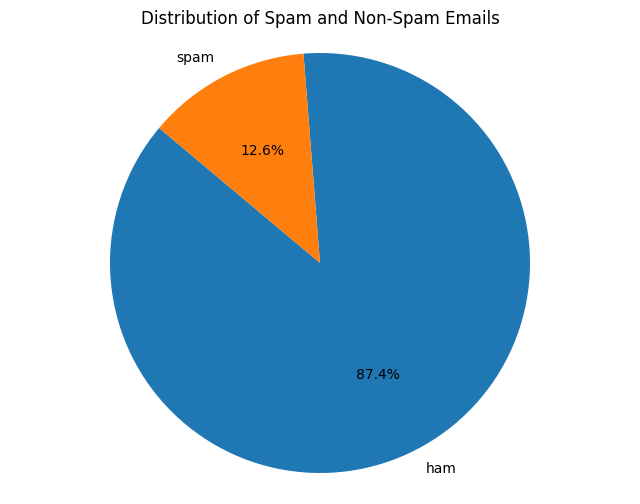

In [66]:
labels = data['result'].value_counts()

# Plotting
plt.figure(figsize=(8, 6))
plt.pie(x=labels, labels=labels.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Spam and Non-Spam Emails')
plt.axis('equal')
plt.show()

As we can see from the above graph, the majority of emails in the dataset (87.4%) are categorized as ham, or non-spam, while only a smaller percentage (12.6%) are spam. This discrepancy matters since it influences our model's ability to identify spam emails. Given the large number of non-spam emails, the model may get skewed and overlook certain spam emails. To address this, we must train and test our model using certain methods. By doing this, we can ensure that our model is capable of identifying spam emails as well as non-spam emails, protecting our inboxes and preventing clutter.

In [67]:
data['Length'] = [len(email) for email in data['emails']] #calculating length of each email
data['num_words'] = [len(word_tokenize(email)) for email in data['emails']] #calculating number of words in each email
data['num_sentence'] = [len(sent_tokenize(email)) for email in data['emails']] #calculating number of sentences in each email

In [68]:
data.head()

,result,emails,Length,num_words,num_sentence
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2
1,ham,Ok lar... Joking wif u oni...,29,8,2
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,ham,U dun say so early hor... U c already then say...,49,13,1
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [69]:
len(data.iloc[0]['emails'])

111

**2) Average Length of Emails for Spam and Ham**

In [70]:
#calculate average length of spam and ham emails
avg_length_spam = data[data['result'] == 'spam']['Length'].mean()
avg_length_ham = data[data['result'] == 'ham']['Length'].mean()
print(f"Average Length of Spam Emails: {avg_length_spam: .2f}")
print(f"Average Length of Ham Emails: {avg_length_ham: .2f}")

Average Length of Spam Emails:  137.89
Average Length of Ham Emails:  70.46


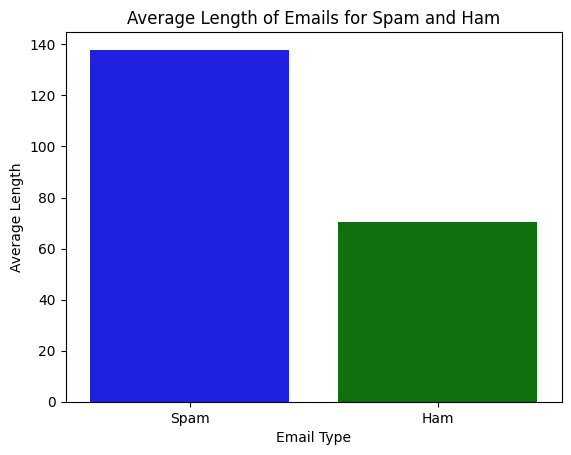

In [71]:
#plotting the bar graph
sns.barplot(
    x=['Spam', 'Ham'], 
    y=[avg_length_spam, avg_length_ham], 
    hue=['Spam', 'Ham'], 
    palette=['blue', 'green'], 
    dodge=False, 
    legend=False
    )
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length')
plt.show()

The average length of spam emails is 137 characters, which is significantly longer than the average length of ordinary (ham) emails. Conversely, standard emails are substantially shorter, with an average of roughly 70 characters. This indicates that spam emails typically contain more content and are more wordy, perhaps in an effort to get your attention. Regular emails, such as those you receive for business or from friends, are typically brief and direct. Knowing this enables us to create more effective solutions for removing spam and maintaining the organization of our inboxes.

**3) Average Word of Emails for Spam and Ham**

In [72]:
#calculate average number of words in spam and ham emails
avg_word_spam = data[data['result'] == 'spam']['num_words'].mean()
avg_word_ham = data[data['result'] == 'ham']['num_words'].mean()
print(f"Average Words of Spam Emails: {avg_word_spam:.2f}")
print(f"Average Words of Ham Emails: {avg_word_ham:.2f}")

Average Words of Spam Emails: 27.67
Average Words of Ham Emails: 17.12


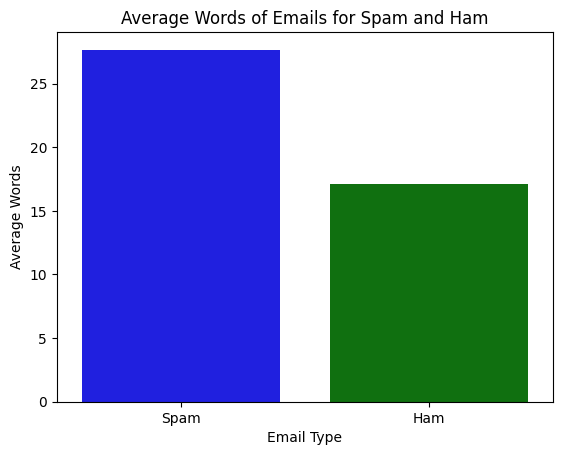

In [73]:
# Plotting the graph
sns.barplot(
    x=['Spam', 'Ham'], 
    y=[avg_word_spam, avg_word_ham], 
    hue=['Spam', 'Ham'], 
    palette=['blue', 'green'], 
    dodge=False, 
    legend=False
    )
plt.title('Average Words of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words')
plt.show()

The graph above shows that spam emails are typically longer—an average of almost 27 words. Regular ham emails, on the other hand, are shorter, with an average of only 17 words. This indicates that spam emails are typically longer, perhaps as a result of the ads or false information they contain. Regular emails, on the other hand, are clearer and more direct. Knowing this makes it simpler to locate the emails that are important to us and helps us develop stronger filters to remove spam and keep our inboxes clear of unsolicited messages.

**4) Average Sentence of Emails for Spam and Ham**

In [74]:
#calculate average number of sentences in spam and ham emails
avg_sentence_spam = data[data['result'] == 'spam']['num_sentence'].mean()
avg_sentence_ham = data[data['result'] == 'ham']['num_sentence'].mean()
print("Average Sentence of Spam Emails:", round(avg_sentence_spam, 2))
print("Average Sentence of Ham Emails:", round(avg_sentence_ham, 2))

Average Sentence of Spam Emails: 2.97
Average Sentence of Ham Emails: 1.82


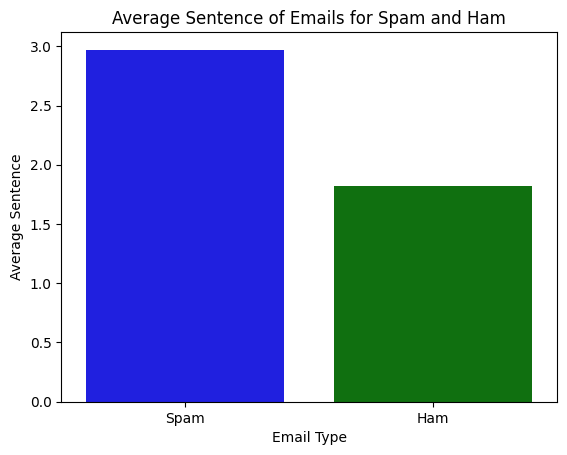

In [75]:
# Plotting the graph
sns.barplot(  
    x=['Spam', 'Ham'], 
    y=[avg_sentence_spam, avg_sentence_ham], 
    hue=['Spam', 'Ham'], 
    palette=['blue', 'green'], 
    dodge=False, 
    legend=False)
plt.title('Average Sentence of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentence')
plt.show()

As can be seen from the accompanying graph, spam emails typically contain longer phrases than other types of emails. Regular emails often have two sentences, however spam emails typically contain three. This means that ordinary emails are typically shorter and more direct, but spam emails may be attempting to say more or persuade you of something. By being aware of this distinction, we can create more effective systems to identify and weed out spam emails, making our inboxes safer and cleaner for everyone to use.

**5) Relationship between Length and Spam**

In [76]:
#correlation coefficient between email length and spam classification
correlation = data['Length'].corr((data['result'] == 'spam').astype(int))
print(correlation)

0.3847170667143076


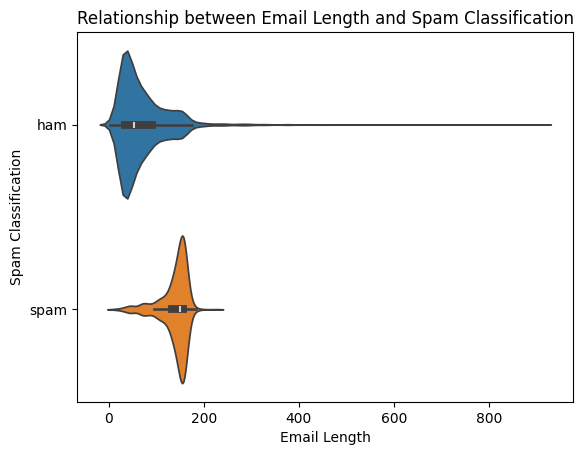

In [77]:
sns.violinplot(data=data, x='Length', y='result', hue='result')
plt.xlabel('Email Length')
plt.ylabel('Spam Classification')
plt.title('Relationship between Email Length and Spam Classification')
plt.show()

We discovered that email length and spam classification have a positive correlation (correlation coefficient: 0.38). This indicates that spam emails are typically a little bit longer than non-spam emails. It is crucial to remember that the association is weak, suggesting that other factors might potentially affect whether an email is deemed spam. However, by taking into account email length as one of the criteria in the classification process, along with other pertinent factors, a knowledge of this link can aid in the improvement of spam detection algorithms.

**6) Relationship between Features**

In [78]:
#the relationship between features
correlation_matrix = data[['Length', 'num_words', 'num_sentence']].corr()
print(correlation_matrix )

                Length  num_words  num_sentence
Length        1.000000   0.965760      0.624139
num_words     0.965760   1.000000      0.679971
num_sentence  0.624139   0.679971      1.000000


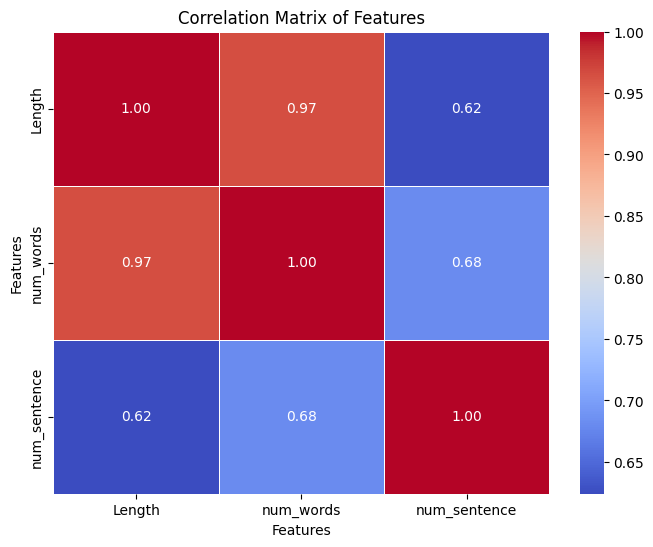

In [79]:
#visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

Strong positive relationships between email length and word count (0.97) and between word count and sentence count (0.68), according to the correlation matrix, are shown. This implies that emails that are longer typically contain more words, and emails that are longer typically contain more sentences. Nevertheless, there is a lesser (0.62) link between email length and sentence count. This suggests that although lengthier emails might contain more sentences, there is not as much of a correlation between the two. By comprehending these connections, we may better understand how various elements contribute to the overall composition and content of emails, which facilitates the classification of spam.

### Data Preprocessing

In [80]:
data['transform_text'] = [email.lower() for email in data['emails']]

#tokenization
data['transform_text'] = [word_tokenize(text) for text in data['transform_text']]

#removing special characters
data['transform_text'] = data['transform_text'].apply(lambda x: [re.sub(r'[^a-zA-Z0-9\s]', '', word) for word in x])

#removing stop words and punctuation
stop_words = set(stopwords.words('english'))
data['transform_text'] = data['transform_text'].apply(lambda x: [word for word in x if word not in stop_words and word not in string.punctuation])

#stemming
ps = PorterStemmer()
data['transform_text'] = data['transform_text'].apply(lambda x: [ps.stem(word) for word in x])

#convert the preprocessed text back to string
data['transform_text'] = data['transform_text'].apply(lambda x: ' '.join(x))

In [81]:
#display the preprocessed data
data[['emails', 'transform_text']].head()

,emails,transform_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah nt think goe usf live around though


In [82]:
data.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,ham,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,ham,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


**7) Most Common Words in Spam Emails**

Top 10 Most Common Words in Spam Emails:
call: 321 occurrences
free: 191 occurrences
2: 157 occurrences
txt: 141 occurrences
u: 135 occurrences
text: 122 occurrences
ur: 119 occurrences
mobil: 114 occurrences
stop: 106 occurrences
repli: 103 occurrences


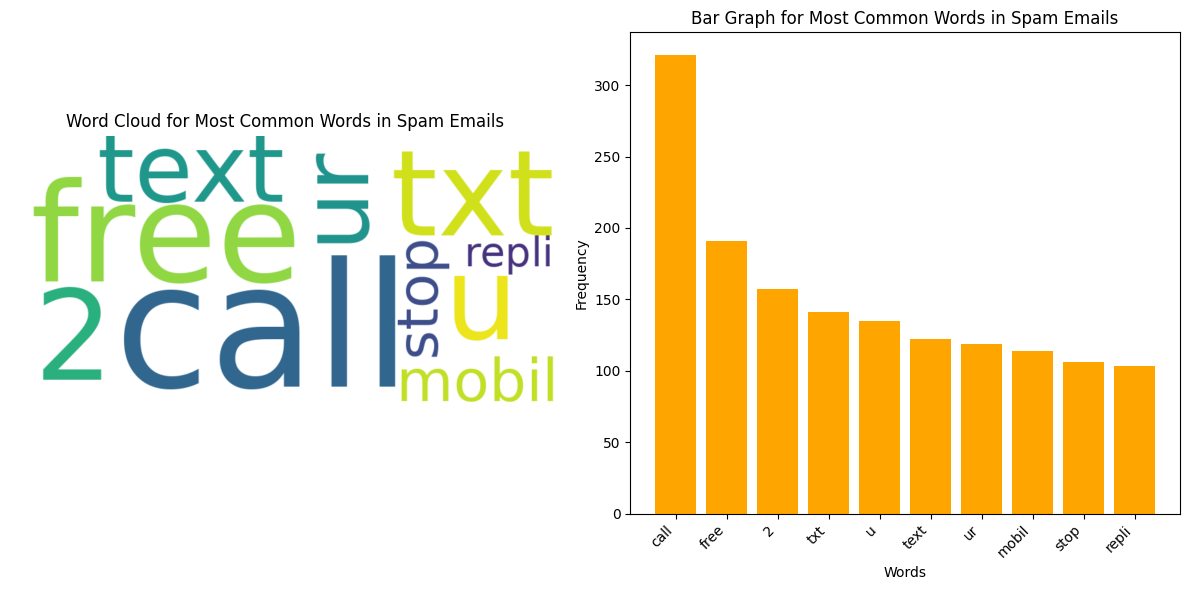

In [83]:
spam_emails = data[data['result'] == 'spam']['transform_text']

#tokenize the text in spam emails
spam_words = ' '.join(spam_emails).split()

#count occurrences of each word
word_counts = Counter(spam_words)

#find the most common words
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in Spam Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")
    
#generate Word Cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    font_path='/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf').generate_from_frequencies(dict(most_common_words)
)
    
#plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in Spam Emails', fontname='DejaVu Sans')
plt.axis('off')

#plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in Spam Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Looking at the most common words found in spam emails, we see patterns that spammers often use to catch our attention or convince us to act. Words like "call," "free," and "txt" show up frequently, suggesting offers or requests for action. This helps us understand what to watch out for in our emails to avoid falling for spam. By knowing these common tricks, we can be more careful about which emails we open or respond to, keeping our inboxes safer. Email filters also use this information to better recognize and block spam messages, making our email experience more secure.

**8) Most Common Words in ham Emails**

Top 10 Most Common Words in ham Emails:
u: 904 occurrences
go: 404 occurrences
nt: 352 occurrences
get: 352 occurrences
2: 290 occurrences
gt: 288 occurrences
lt: 287 occurrences
come: 275 occurrences
ok: 251 occurrences
got: 238 occurrences


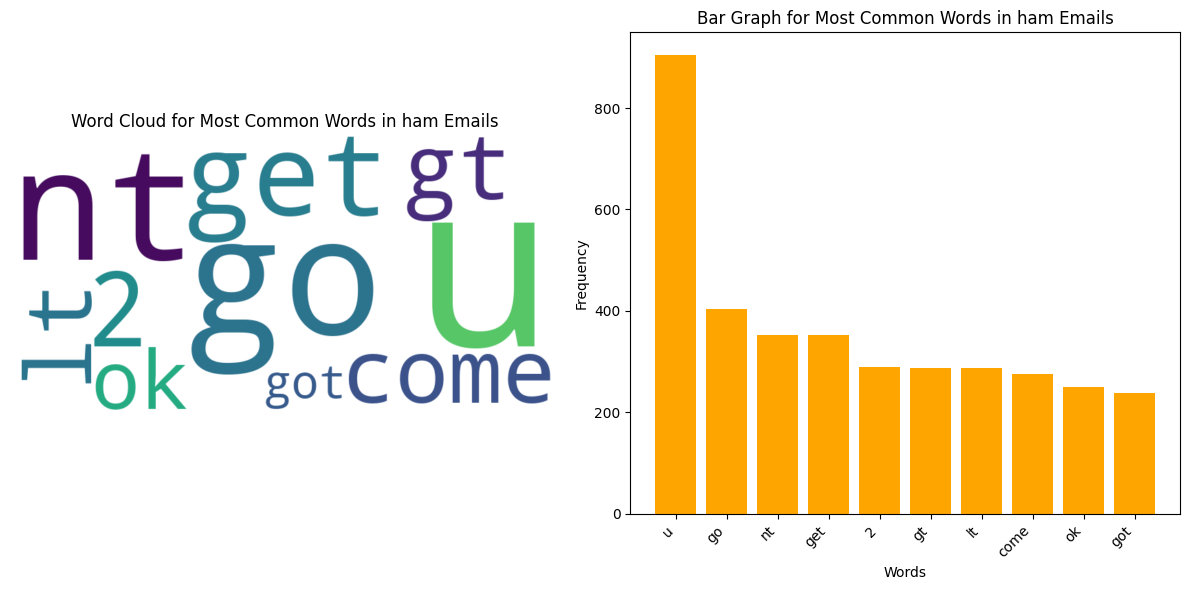

In [84]:
ham_emails = data[data['result'] == 'ham']['transform_text']

# Tokenize the text in spam emails
ham_words = ' '.join(ham_emails).split()

# Count occurrences of each word
word_counts = Counter(ham_words)

# Find the most common words
most_common_words = word_counts.most_common(10)

print("Top 10 Most Common Words in ham Emails:")
for word, count in most_common_words:
    print(f"{word}: {count} occurrences")

# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(most_common_words))

# Plot Word Cloud
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Most Common Words in ham Emails')
plt.axis('off')

# Plot Bar Graph
plt.subplot(1, 2, 2)
words, counts = zip(*most_common_words)
plt.bar(words, counts, color='orange')
plt.title('Bar Graph for Most Common Words in ham Emails')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In non-spam emails, the following ten terms are most frequently used: "u," "go," "nt," "get," "2," "gt," "lt," "come," "ok," and "got." These words demonstrate how individuals communicate via emails, using abbreviations like "u" for "you" and "nt" for "not." They also disclose typical subjects like going somewhere or using "ok" to confirm something. Knowing these terms makes it easier to identify typical emails. It helps us identify odd or dubious messages, such as spam, by letting us know what to anticipate from everyday communications.

### Label Encoding

In [97]:
encoder = LabelEncoder()
data['result'] = encoder.fit_transform(data['result'])

In [98]:
data.sample(5)

,result,emails,Length,num_words,num_sentence,transform_text
3652,0,It has issues right now. Ill fix for her by to...,53,13,2,issu right ill fix tomorrow
4109,0,"Yo, you gonna still be in stock tomorrow/today...",75,18,2,yo gon na still stock tomorrowtoday tri get du...
680,0,What is this 'hex' place you talk of? Explain!,46,12,2,hex place talk explain
4726,1,Had your mobile 10 mths? Update to the latest ...,143,30,4,mobil 10 mth updat latest cameravideo phone fr...
4548,0,"Haha, my friend tyler literally just asked if ...",73,15,1,haha friend tyler liter ask could get dubsack


### Model Building

In [99]:
#convert the input data into vector , so here we will use TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(data['transform_text']).toarray()
y = data['result']

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [89]:
X.shape

(5169, 3000)

#### Model 1) SVC

In [100]:
svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)
y_pred_svc = svc_classifier.predict(X_test)
accuracy_svc = accuracy_score(y_test, y_pred_svc)
print(f"SVM Accuracy: {accuracy_svc:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_svc))
print("Precision Score: ",precision_score(y_test,y_pred_svc))

SVM Accuracy: 0.98
confusion Matrix : [[889   0]
 [ 24 121]]
Precision Score:  1.0


#### Model 2) Random Forest classifier

In [101]:
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_rf))
print("Precision Score: ",precision_score(y_test,y_pred_rf))

Random Forest Accuracy: 0.98
confusion Matrix : [[887   2]
 [ 23 122]]
Precision Score:  0.9838709677419355


#### Model 3) Naive Bayes classifier

In [102]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred_nb = nb_classifier.predict(X_test)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb:.2f}")
print("confusion Matrix :",confusion_matrix(y_test,y_pred_nb))
print("Precision Score: ",precision_score(y_test,y_pred_nb))

Naive Bayes Accuracy: 0.98
confusion Matrix : [[888   1]
 [ 24 121]]
Precision Score:  0.9918032786885246


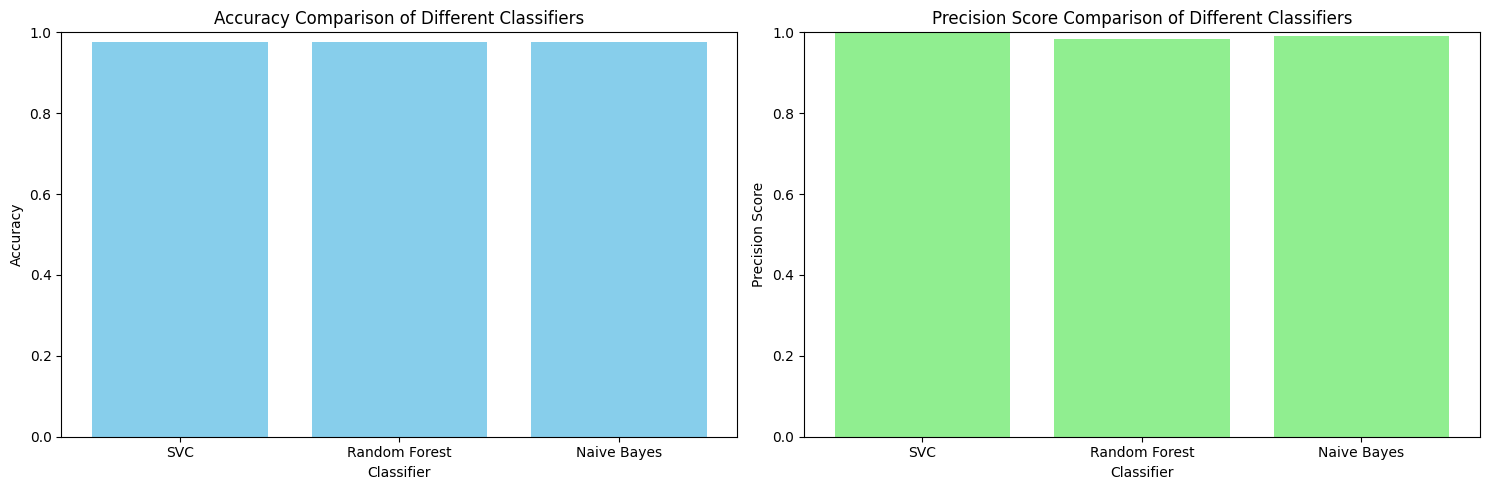

In [103]:
# Calculate precision scores for each classifier
precision_svc = precision_score(y_test, y_pred_svc)
precision_rf = precision_score(y_test, y_pred_rf)
precision_nb = precision_score(y_test, y_pred_nb)

# Create lists to store accuracies and precision scores
classifiers = ['SVC', 'Random Forest', 'Naive Bayes']
accuracies = [accuracy_svc, accuracy_rf, accuracy_nb]
precision_scores = [precision_svc, precision_rf, precision_nb]

# Plot bar graph for accuracies and precision scores side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot bar graph for accuracies
axes[0].bar(classifiers, accuracies, color='skyblue')
axes[0].set_xlabel('Classifier')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy Comparison of Different Classifiers')
axes[0].set_ylim(0, 1)

# Plot bar graph for precision scores
axes[1].bar(classifiers, precision_scores, color='lightgreen')
axes[1].set_xlabel('Classifier')
axes[1].set_ylabel('Precision Score')
axes[1].set_title('Precision Score Comparison of Different Classifiers')
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


SVC is the model that performs the best after sorting. Therefore, we will utilize SVC to forecast prices using svc.predict(). This procedure aids in the selection of the most predictive model.

### Model Prediction

In [94]:
new_emails = [
    "Get a free iPhone now!",
    "Hey, how's it going?",
    "Congratulations! You've won a prize!",
    "Reminder: Meeting at 2 PM tomorrow."
]

# Convert new data into numerical vectors using the trained tfidf_vectorizer
new_X = tfidf.transform(new_emails)
new_X_dense = new_X.toarray()

# Use the trained SVM model to make predictions
svm_predictions = svc_classifier.predict(new_X_dense)

# Print the predictions
for email, prediction in zip(new_emails, svm_predictions):
    if prediction == 1:
        print(f"'{email}' is predicted as spam.")
    else:
        print(f"'{email}' is predicted as ham.")

'Get a free iPhone now!' is predicted as ham.
'Hey, how's it going?' is predicted as ham.
'Congratulations! You've won a prize!' is predicted as spam.
'Reminder: Meeting at 2 PM tomorrow.' is predicted as ham.


### User Input Data Prediction

In [104]:
def predict_email(email):
    # Convert email into numerical vector using the trained TF-IDF vectorizer
    email_vector = tfidf.transform([email])

    # Convert sparse matrix to dense array
    email_vector_dense = email_vector.toarray()

    # Use the trained SVM model to make predictions
    prediction = svc_classifier.predict(email_vector_dense)

    # Print the prediction
    if prediction[0] == 1:
        print("The email is predicted as spam.")
    else:
        print("The email is predicted as ham.")

# Get user input for email
user_email = input("Enter the email text: ")

# Predict whether the input email is spam or ham
predict_email(user_email)

The email is predicted as ham.


In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Punctuations
import string
# Pandas
import pandas as pd
# Remove Stopwords
from nltk.corpus import stopwords
# Regular Expressions
import re
# Import PorterStemmer from NLTK Library
from nltk.stem.porter import PorterStemmer
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB , MultinomialNB , BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# Metrix and Train Test
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [106]:
data.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [107]:
print(f'Null Values in Train Dataset is : {data.isnull().sum().sum()}')

Null Values in Train Dataset is : 0


In [41]:
# Duplicates
print(f"Duplicates values in Train Dataset is : {data.duplicated().sum()}")

Duplicates values in Train Dataset is : 0


In [42]:
data.isnull().sum()

result            0
emails            0
Length            0
num_words         0
num_sentence      0
transform_text    0
dtype: int64

In [108]:
print(data['transform_text'][0])
print(data['transform_text'][1])
print(data['transform_text'][2])

go jurong point crazi avail bugi n great world la e buffet cine got amor wat
ok lar joke wif u oni
free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri question std txt rate c appli 08452810075over18


In [44]:
# 1. LowerCase
data['transform_text'] = data['transform_text'].str.lower()

# Head
data.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [109]:
df_train=data

In [46]:
df_train['transform_text'] = df_train['transform_text'].str.replace('#','')
df_train['transform_text'] = df_train['transform_text'].str.replace('@','')
df_train['transform_text'] = df_train['transform_text'].str.replace(r'^https?:\/\/.*[\r\n]*','')

In [47]:
import string
df_train['transform_text'] = df_train['transform_text'].str.translate(str.maketrans('', '', string.punctuation))

# Head
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [110]:
# 6. Intilize Stopwords
stop_words = stopwords.words('english')

# Apply Stopwords
df_train['transform_text'] = df_train['transform_text'].apply(lambda x : ' '.join([word for word in x.split()if word not in (stop_words)]))

# Head
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [111]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [112]:
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

# Calling Function
df_train['transform_text'] = df_train['transform_text'].apply(chat_conversion)

# Head
df_train.head()


,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [113]:
# 7. Handling ChatWords
# Function
def chat_conversion(text):
    new_text = []
    for i in text.split():
        if i.upper() in chat_words:
            new_text.append(chat_words[i.upper()])
        else:
            new_text.append(i)
    return " ".join(new_text)

# Calling Function
df_train['transform_text'] = df_train['transform_text'].apply(chat_conversion)

# Head
df_train.head()


,result,emails,Length,num_words,num_sentence,transform_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though


In [114]:
# 8. Tokenization
from nltk.tokenize import sent_tokenize

# Apply sent_tokenize
df_train['text_sent_token'] = df_train['transform_text'].apply(sent_tokenize)

# Head
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text,text_sent_token
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...,[go jurong point crazi avail bugi n great worl...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni,[ok lar joke wif You oni]
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...,[free entri 2 wkli comp win fa cup final tkt 2...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say,[You dun say earli hor You c alreadi say]
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though,[nah nt think goe usf live around though]


In [115]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/mulombi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mulombi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mulombi/nltk_data...


True

In [116]:
# 9. Stemming

# Intilize Stemmer
stemmer = PorterStemmer()

# This Function Will Stem Words
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

# Calling
df_train['stem_msg'] = df_train['transform_text'].apply(stem_words)

# Head
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text,text_sent_token,stem_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...,[go jurong point crazi avail bugi n great worl...,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni,[ok lar joke wif You oni],ok lar joke wif you oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...,[free entri 2 wkli comp win fa cup final tkt 2...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say,[You dun say earli hor You c alreadi say],you dun say earli hor you c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though,[nah nt think goe usf live around though],nah nt think goe usf live around though


In [117]:
cv = CountVectorizer()

In [118]:
X = cv.fit_transform(df_train['stem_msg']).toarray()

In [119]:
# Intlize CountVectorizer
cv = CountVectorizer()

# Fitting CountVectorizer on X
X = cv.fit_transform(df_train['stem_msg']).toarray()

In [120]:
X.shape

(5169, 7510)

In [121]:
y = df_train['result']

In [122]:
y.shape

(5169,)

In [123]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Fitting Encoder
y = le.fit_transform(y)

# Y Values
y

array([0, 0, 1, ..., 0, 0, 0])

In [124]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [125]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
xgb = XGBClassifier(n_estimators=50, random_state=2)

In [126]:
# Initlize Models
# Support Vector MAchine
svc = SVC(kernel='sigmoid', gamma=1.0)
# KNeighbours
knc = KNeighborsClassifier()
# Multinomial NaiveBayes
mnb = MultinomialNB()
# Decision Tree
dtc = DecisionTreeClassifier(max_depth=5)
# Logistic Regression
lrc = LogisticRegression(solver='liblinear', penalty='l1')
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
# AddaBoost Classifier
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
# Extra Tree Classifier a Ensemble Method
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
# XGB Classifier
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [127]:
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

In [128]:
knc.fit(X_train, y_train)
knn_pred = knc.predict(X_test)

In [129]:
mnb.fit(X_train, y_train)
mnb_pred = mnb.predict(X_test)

In [130]:
dtc.fit(X_train, y_train)
dtc_pred = dtc.predict(X_test)

In [131]:
lrc.fit(X_train, y_train)
lrc_pred = lrc.predict(X_test)

In [132]:
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

In [133]:
abc.fit(X_train, y_train)
abc_pred = abc.predict(X_test)

/home/mulombi/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [134]:
etc.fit(X_train, y_train)
etc_pred = etc.predict(X_test)

In [135]:
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

In [137]:
# Fitting Each Model One by One
# 1. SVC
svc.fit(X_train ,y_train)
# Pred
svc_pred = svc.predict(X_test)
#-----------------------------
# 2. KNeighbours
knc.fit(X_train ,y_train)
# Pred
knn_pred = knc.predict(X_test)
#-----------------------------
# 3. Multinomial NaiveBayes
mnb.fit(X_train ,y_train)
# Pred
mnb_pred = mnb.predict(X_test)
#-----------------------------
# 4. Decision Tree
dtc.fit(X_train ,y_train)
# Pred
dtc_pred = dtc.predict(X_test)
#-----------------------------
# 5. Logistic Regression
lrc.fit(X_train ,y_train)
# Pred
lrc_pred = lrc.predict(X_test)
#-----------------------------
# 6. Random Forest Classifier
rfc.fit(X_train ,y_train)
# Pred
rfc_pred = rfc.predict(X_test)
#-----------------------------
# 7. AddaBoost Classifier
abc.fit(X_train ,y_train)
# Pred
abc_pred = abc.predict(X_test)
#-----------------------------
# 8.Extra Tree Classifier a Ensemble Method
etc.fit(X_train ,y_train)
# Pred
etc_pred = etc.predict(X_test)
#-----------------------------
# 9. XGB Classifier
xgb.fit(X_train ,y_train)
# Pred
xgb_pred = xgb.predict(X_test)
#-----------------------------


/home/mulombi/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [138]:
def evaluate(y_test, svc_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  confusion = confusion_matrix(y_test, y_pred)
  return accuracy, precision, confusion

In [139]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

def evaluate(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)

    return accuracy, precision, confusion

In [140]:
accuracy_SVC, precision_SVC, confusion_SVC = evaluate(y_test, svc_pred)
print(f"The Accuracy Score Of SVC is {accuracy_SVC}, Precision Is {precision_SVC},\nConfusion Matrix is \n{confusion_SVC} ")

The Accuracy Score Of SVC is 0.9081237911025145, Precision Is 0.725,
Confusion Matrix is 
[[852  33]
 [ 62  87]] 


In [141]:
accuracy_KNN, precision_KNN, confusion_KNN = evaluate(y_test, knn_pred)
print(f"The Accuracy Score Of KNN is {accuracy_KNN}, Precision Is {precision_KNN},\nConfusion Matrix is \n{confusion_KNN} ")

The Accuracy Score Of KNN is 0.8984526112185687, Precision Is 1.0,
Confusion Matrix is 
[[885   0]
 [105  44]] 


In [142]:
accuracy_MNB, precision_MNB, confusion_MNB = evaluate(y_test, mnb_pred)
print(f"The Accuracy Score Of MultinomialNB is {accuracy_MNB}, Precision Is {precision_MNB},\nConfusion Matrix is \n{confusion_MNB} ")

The Accuracy Score Of MultinomialNB is 0.9758220502901354, Precision Is 0.9246575342465754,
Confusion Matrix is 
[[874  11]
 [ 14 135]] 


In [143]:
accuracy_DTC, precision_DTC, confusion_DTC = evaluate(y_test, dtc_pred)
print(f"The Accuracy Score Of Decision Tree is {accuracy_DTC}, Precision Is {precision_DTC},\nConfusion Matrix is \n{confusion_DTC} ")

The Accuracy Score Of Decision Tree is 0.9284332688588007, Precision Is 0.9411764705882353,
Confusion Matrix is 
[[880   5]
 [ 69  80]] 


In [144]:
accuracy_LR, precision_LR, confusion_LR = evaluate(y_test, lrc_pred)
print(f"The Accuracy Score Of Logistic Regression is {accuracy_LR}, Precision Is {precision_LR},\nConfusion Matrix is \n{confusion_LR} ")

The Accuracy Score Of Logistic Regression is 0.9738878143133463, Precision Is 0.9692307692307692,
Confusion Matrix is 
[[881   4]
 [ 23 126]] 


In [145]:
accuracy_RF, precision_RF, confusion_RF = evaluate(y_test, rfc_pred)
print(f"The Accuracy Score Of Random Forest Classifier is {accuracy_RF}, Precision Is {precision_RF},\nConfusion Matrix is \n{confusion_RF} ")

The Accuracy Score Of Random Forest Classifier is 0.9690522243713733, Precision Is 1.0,
Confusion Matrix is 
[[885   0]
 [ 32 117]] 


In [146]:
accuracy_ADC, precision_ADC, confusion_ADC = evaluate(y_test, abc_pred)
print(f"The Accuracy Score Of AdaBoost Classifier is {accuracy_ADC}, Precision Is {precision_ADC},\nConfusion Matrix is \n{confusion_ADC} ")

The Accuracy Score Of AdaBoost Classifier is 0.9709864603481625, Precision Is 0.983739837398374,
Confusion Matrix is 
[[883   2]
 [ 28 121]] 


In [147]:
accuracy_ETC, precision_ETC, confusion_ETC = evaluate(y_test, etc_pred)
print(f"The Accuracy Score Of Extra Tree Classifier is {accuracy_ETC}, Precision Is {precision_ETC},\nConfusion Matrix is \n{confusion_ETC} ")

The Accuracy Score Of Extra Tree Classifier is 0.971953578336557, Precision Is 0.9918032786885246,
Confusion Matrix is 
[[884   1]
 [ 28 121]] 


In [148]:
accuracy_XGB, precision_XGB, confusion_XGB = evaluate(y_test, xgb_pred)
print(f"The Accuracy Score Of XGBoost Classifier is {accuracy_XGB}, Precision Is {precision_XGB},\nConfusion Matrix is \n{confusion_XGB} ")

The Accuracy Score Of XGBoost Classifier is 0.9748549323017408, Precision Is 0.992,
Confusion Matrix is 
[[884   1]
 [ 25 124]] 


In [150]:
# 1. SVC
accuracy_SVC , precision_SVC , confusion_SVC = evaluate(y_test,svc_pred)
print(f"The Accuracy Score Of SVC is {accuracy_SVC} , Precision Is {precision_SVC} ,\nConfusion Matrix is \n{confusion_SVC} ")

print("\n")

# 2. KNN
accuracy_KNN , precision_KNN , confusion_KNN = evaluate(y_test,knn_pred)
print(f"The Accuracy Score Of KNN is {accuracy_KNN} , Precision Is {precision_KNN} ,\nConfusion Matrix is \n{confusion_KNN} ")

print("\n")

# 3.Multinomial
accuracy_MNB , precision_MNB , confusion_MNB = evaluate(y_test,mnb_pred)
print(f"The Accuracy Score Of MultinomialNB is {accuracy_MNB} , Precision Is {precision_MNB} ,\nConfusion Matrix is \n{confusion_MNB} ")

print("\n")

# 4.Decision Tree
accuracy_DTC , precision_DTC , confusion_DTC = evaluate(y_test,dtc_pred)
print(f"The Accuracy Score Of Decision Tree is {accuracy_DTC} , Precision Is {precision_DTC} ,\nConfusion Matrix is \n{confusion_DTC} ")

print("\n")

# 5.Logistic Regression
accuracy_LR , precision_LR , confusion_LR = evaluate(y_test,lrc_pred)
print(f"The Accuracy Score Of Logistic Regression is {accuracy_LR} , Precision Is {precision_LR} ,\nConfusion Matrix is \n{confusion_LR} ")

print("\n")

# 6.Random Forest Classifier
accuracy_RF , precision_RF , confusion_RF = evaluate(y_test,rfc_pred)
print(f"The Accuracy Score Of Random Forest Classifier is {accuracy_RF} , Precision Is {precision_RF} ,\nConfusion Matrix is \n{confusion_RF} ")

print("\n")

# 7.AddaBoost Classifier
accuracy_ADC , precision_ADC , confusion_ADC = evaluate(y_test,abc_pred)
print(f"The Accuracy Score Of AddaBoost Classifier is {accuracy_ADC} , Precision Is {precision_ADC} ,\nConfusion Matrix is \n{confusion_ADC} ")

print("\n")

# 8.Extra Tree Classifier a Ensemble Method
accuracy_ETC , precision_ETC , confusion_ETC = evaluate(y_test,etc_pred)
print(f"The Accuracy Score Of Extra Tree Classifier  is {accuracy_ETC} , Precision Is {precision_ETC} ,\nConfusion Matrix is \n{confusion_ETC} ")

print("\n")

# 9. XGB Classifier
accuracy_XGB , precision_XGB , confusion_XGB = evaluate(y_test,xgb_pred)
print(f"The Accuracy Score Of XGB Classifier is {accuracy_XGB} , Precision Is {precision_XGB} ,\nConfusion Matrix is \n{confusion_XGB} ")

The Accuracy Score Of SVC is 0.9081237911025145 , Precision Is 0.725 ,
Confusion Matrix is 
[[852  33]
 [ 62  87]] 


The Accuracy Score Of KNN is 0.8984526112185687 , Precision Is 1.0 ,
Confusion Matrix is 
[[885   0]
 [105  44]] 


The Accuracy Score Of MultinomialNB is 0.9758220502901354 , Precision Is 0.9246575342465754 ,
Confusion Matrix is 
[[874  11]
 [ 14 135]] 


The Accuracy Score Of Decision Tree is 0.9284332688588007 , Precision Is 0.9411764705882353 ,
Confusion Matrix is 
[[880   5]
 [ 69  80]] 


The Accuracy Score Of Logistic Regression is 0.9738878143133463 , Precision Is 0.9692307692307692 ,
Confusion Matrix is 
[[881   4]
 [ 23 126]] 


The Accuracy Score Of Random Forest Classifier is 0.9690522243713733 , Precision Is 1.0 ,
Confusion Matrix is 
[[885   0]
 [ 32 117]] 


The Accuracy Score Of AddaBoost Classifier is 0.9709864603481625 , Precision Is 0.983739837398374 ,
Confusion Matrix is 
[[883   2]
 [ 28 121]] 


The Accuracy Score Of Extra Tree Classifier  is 0.971

In [151]:
evaluation_data = {
    'Model': ['SVC', 'KNN', 'MultinomialNB', 'Decision Tree', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'Extra Tree', 'XGBoost'],
    'Accuracy': [accuracy_SVC, accuracy_KNN, accuracy_MNB, accuracy_DTC, accuracy_LR, accuracy_RF, accuracy_ADC, accuracy_ETC, accuracy_XGB],
    'Precision': [precision_SVC,precision_KNN, precision_MNB, precision_DTC, precision_LR, precision_RF, precision_ADC, precision_ETC, precision_XGB]
}

In [152]:
evaluation_df = pd.DataFrame(evaluation_data)

In [155]:
evaluation_df = evaluation_df.sort_values(by=['Accuracy','Precision'], ascending=False)

In [156]:
evaluation_df

,Model,Accuracy,Precision
2,MultinomialNB,0.975822,0.924658
8,XGBoost,0.974855,0.992000
4,Logistic Regression,0.973888,0.969231
7,Extra Tree,0.971954,0.991803
6,AdaBoost,0.970986,0.983740
5,Random Forest,0.969052,1.000000
3,Decision Tree,0.928433,0.941176
0,SVC,0.908124,0.725000
1,KNN,0.898453,1.000000


In [157]:
import plotly.graph_objects as go

# Define the models and their accuracies and precisions
models = ['SVC', 'KNN', 'MultinomialNB', 'Decision Tree', 'Logistic Regression', 'Random Forest', 'AdaBoost', 'Extra Tree', 'XGBoost']
accuracies = [accuracy_SVC, accuracy_KNN, accuracy_MNB, accuracy_DTC, accuracy_LR, accuracy_RF, accuracy_ADC, accuracy_ETC, accuracy_XGB]
precisions = [precision_SVC, precision_KNN, precision_MNB, precision_DTC, precision_LR, precision_RF, precision_ADC, precision_ETC, precision_XGB]

# Create the figure
fig = go.Figure()

# Add bar traces for accuracy and precision
fig.add_trace(go.Bar(
    x=models,
    y=accuracies,
    name='Accuracy',
    marker_color='skyblue'
))
fig.add_trace(go.Bar(
    x=models,
    y=precisions,
    name='Precision',
    marker_color='salmon'
))

# Update layout
fig.update_layout(
    title='Accuracy and Precision of Different Models',
    xaxis=dict(title='Models'),
    yaxis=dict(title='Score'),
    barmode='group'  # Group bars for each model
)

# Show the plot
fig.show()

In [158]:
df_train.head()

,result,emails,Length,num_words,num_sentence,transform_text,text_sent_token,stem_msg
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...,[go jurong point crazi avail bugi n great worl...,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif You oni,[ok lar joke wif You oni],ok lar joke wif you oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...,[free entri 2 wkli comp win fa cup final tkt 2...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,You dun say earli hor You c alreadi say,[You dun say earli hor You c alreadi say],you dun say earli hor you c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah nt think goe usf live around though,[nah nt think goe usf live around though],nah nt think goe usf live around though


In [159]:
df_train['stem_msg'][2]

'free entri 2 wkli comp win fa cup final tkt 21st may 2005 text fa 87121 receiv entri question std txt rate c appli 08452810075over18'

In [160]:

# Predict Messgae
ham_messages = [
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr",
    "WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim...",
    "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enou.."
]

# Preprocess Text
preprocessed_messages = []
for msg in ham_messages:
    # Lower case
    msg = msg.lower()
    # Remove punctuation
    msg = msg.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    msg = ' '.join([word for word in msg.split() if word not in stopwords.words('english')])
    preprocessed_messages.append(msg)

# Vectorize the preprocessed messages using the same vectorizer used during training
X_input = cv.transform(preprocessed_messages).toarray()

# Predict the class label for the vectorized text messages
predicted_labels = xgb.predict(X_input)

# Print the predicted label for each message
for idx, msg in enumerate(preprocessed_messages):
    if predicted_labels[idx] == 0:
        print(f"Message: '{msg}' - Predicted Label: Ham")
    else:
        print(f"Message: '{msg}' - Predicted Label: Spam")


Message: 'free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entr' - Predicted Label: Spam
Message: 'winner valued network customer selected receivea £900 prize reward claim' - Predicted Label: Spam
Message: 'im gonna home soon dont want talk stuff anymore tonight k ive cried enou' - Predicted Label: Ham
